In [1]:
!pip install pandas
!pip install seaborn
!pip install numpy
!pip install scipy
!pip install matplotlib

In [2]:
import os
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.patches import Patch
from matplotlib import colormaps
np.random.seed(41)
#plt.switch_backend('TkAgg')
from scipy.stats import spearmanr
def calculate_dissimilarity(rating):
    dissimilarity = (9 - rating) / 8
    return dissimilarity

adjacency_matrix = np.zeros((33, 33))
materials = {}
p = 0
pcount = 0



for filename in os.listdir('./data'):
    p = p+1
    filename = "A ("+ str(p)+").txt"   
        
    data = pd.read_csv("./data/"+filename)
    if(data.shape[0] == 528):          
        duplicated_pairs = data.iloc[:, [1, 2]].duplicated()
        if any(duplicated_pairs):
            continue  
        else:
            pcount += 1
            for index, row in data.iterrows():
                material1, material2, rating = row[1], row[2], row[0]
                material1 = material1.replace(" ","")
                material2 = material2.replace(" ","")
                # Calculate dissimilarity
                dissimilarity = calculate_dissimilarity(rating)

                key = tuple(sorted([material1.strip(), material2.strip()]))
                
                if (key not in materials.keys()):
                    materials[key] = []
                if (key in materials.keys()):
                    materials[key].append(dissimilarity)
                    
                

materials2 = {}
for key in materials.keys():
    if (key not in materials2.keys()):
        materials2[key] = []
    materials2[key] = materials[key]
    for i in range(0,len(key)):
        materials[key][i] = abs( materials[key][i])
    materials[key] = np.mean(np.array(materials[key]))
        



In [3]:
materials_index = {}
for key in materials.keys():
    mat1 = key[0]
    mat2 = key[1]
    if(mat1 not in materials_index.keys()):
        materials_index[mat1]="0"
    if(mat2 not in materials_index.keys()):
        materials_index[mat2]="0"


In [4]:
i = 0
for key in materials_index.keys():
    materials_index[key] = i
    i = i+1

In [5]:
for key in materials.keys():
    index1 = materials_index[key[0]]
    index2 = materials_index[key[1]]
    adjacency_matrix[index1,index2] = materials[key]
    adjacency_matrix[index2,index1] = materials[key]


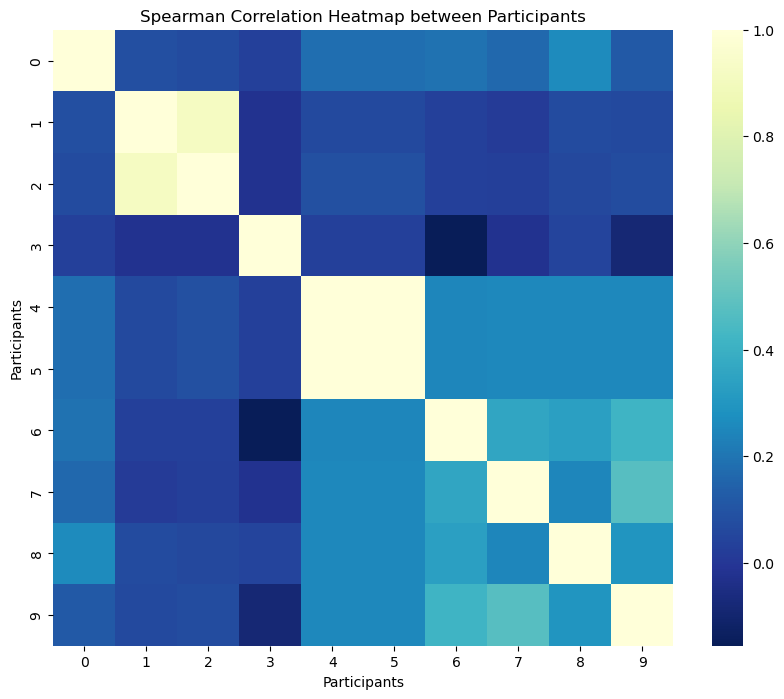

In [6]:
participant_data = {}
for i in range(0,pcount):
    current_part = []
    for j in range(0,len(materials2.keys())):
        current_part.append(materials2[list(materials2.keys())[j]][i])
    if i not in participant_data.keys():
        participant_data[i] = []
    participant_data[i] = current_part

num_participants = len(participant_data)

# Calculate Spearman correlations for each participant across the surface pairs
spearman_corr = np.zeros((num_participants, num_participants))
for i, (pid1, data1) in enumerate(participant_data.items()):
    for j, (pid2, data2) in enumerate(participant_data.items()):
        spearman_corr[i, j] = spearmanr(data1, data2).correlation

# Plot heatmap for Spearman correlations between participants
plt.figure(figsize=(10, 8))
sns.heatmap(spearman_corr, cmap='YlGnBu_r', fmt='.2f')
plt.title('Spearman Correlation Heatmap between Participants')
plt.xlabel('Participants')
plt.ylabel('Participants')
plt.show()


In [7]:
mat_keys = {}
q = 0
for key in materials_index.keys():
    mat_keys[q] = key
    q = q+1

In [8]:
def calculate_stress_with_disparity(X, disparities):
    n = len(X)
    stress = 0.0
    sum_squared_distances = 0.0
    sum_squared_disparities = 0.0
    
    for i in range(n):
        for j in range(i + 1, n):
            d_hat = np.linalg.norm(X[i] - X[j])  # Euclidean distance in reduced space
            distance_ij = d_hat 
            
            sum_squared_distances += distance_ij ** 2
            sum_squared_disparities += disparities[i, j] ** 2
            
            stress += (distance_ij - disparities[i, j]) ** 2
    
    stress = np.sqrt(stress / sum_squared_distances)
    return stress

def transform_to_disparity(dissimilarities):
    return np.square(dissimilarities) 

def nmds_with_disparity(dissimilarities, dimensions_range):
    n = len(dissimilarities)
    stress_values = []
    optimal_dimension = None
    optimal_stress = float('inf')
    optimal_X = None
    
    disparities = transform_to_disparity(dissimilarities)  # Convert dissimilarities to disparities
    
    for dim in dimensions_range:
        X = np.random.rand(n, dim)
        
        # Gradient descent to minimize stress with disparities
        learning_rate = 0.01
        num_iterations = 50
        for _ in range(num_iterations):
            gradient = np.zeros((n, dim))
            
            for i in range(n):
                for j in range(i + 1, n):
                    d_hat = np.linalg.norm(X[i] - X[j])
                    delta_d = d_hat - disparities[i, j]
                    
                    if d_hat != 0:
                        gradient[i] += 2 * delta_d * (X[i] - X[j]) / d_hat
                        gradient[j] += 2 * delta_d * (X[j] - X[i]) / d_hat
            
            # Update coordinates using gradient descent
            X -= learning_rate * gradient
        
        stress = calculate_stress_with_disparity(X, disparities)
        stress_values.append(stress)

    
    return stress_values

stress_val = nmds_with_disparity(adjacency_matrix,range(1,11))

Text(0, 0.5, 'Stress Values')

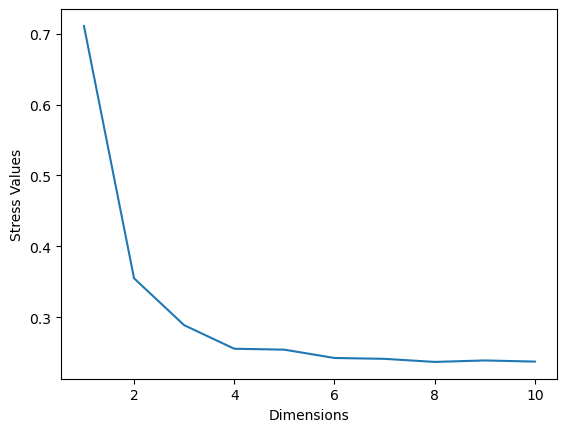

In [9]:
plt.plot(range(1,11),stress_val)
plt.xlabel('Dimensions')
plt.ylabel('Stress Values')

In [10]:
import numpy as np
import matplotlib.pyplot as plt
diff = np.diff(np.array(stress_val))
curvature = np.diff(diff)
elbow_index = np.argmax(curvature) + 1
optim_stress_dim = elbow_index + 1
optimum_stress = stress_val[optim_stress_dim-1]
print("Optimum Stress: "+str(optimum_stress))
print("Optimum Dimension: "+str(optim_stress_dim))

Optimum Stress: 0.3548785836775515
Optimum Dimension: 2


In [11]:
def get_optimal_X(dissimilarities, optimal_dimension):
    n = len(dissimilarities)
    disparities = transform_to_disparity(dissimilarities)  # Convert dissimilarities to disparities
    X = np.random.rand(n, optimal_dimension)  # Random initialization for the given dimension
    
    # Gradient descent to minimize stress with disparities for the given dimension
    learning_rate = 0.01
    num_iterations = 50
    for _ in range(num_iterations):
        gradient = np.zeros((n, optimal_dimension))
        
        for i in range(n):
            for j in range(i + 1, n):
                d_hat = np.linalg.norm(X[i] - X[j])
                delta_d = d_hat - disparities[i, j]
                
                if d_hat != 0:
                    gradient[i] += 2 * delta_d * (X[i] - X[j]) / d_hat
                    gradient[j] += 2 * delta_d * (X[j] - X[i]) / d_hat
        
        # Update coordinates using gradient descent
        X -= learning_rate * gradient
    
    return X


optimal_X = get_optimal_X(adjacency_matrix, optim_stress_dim)


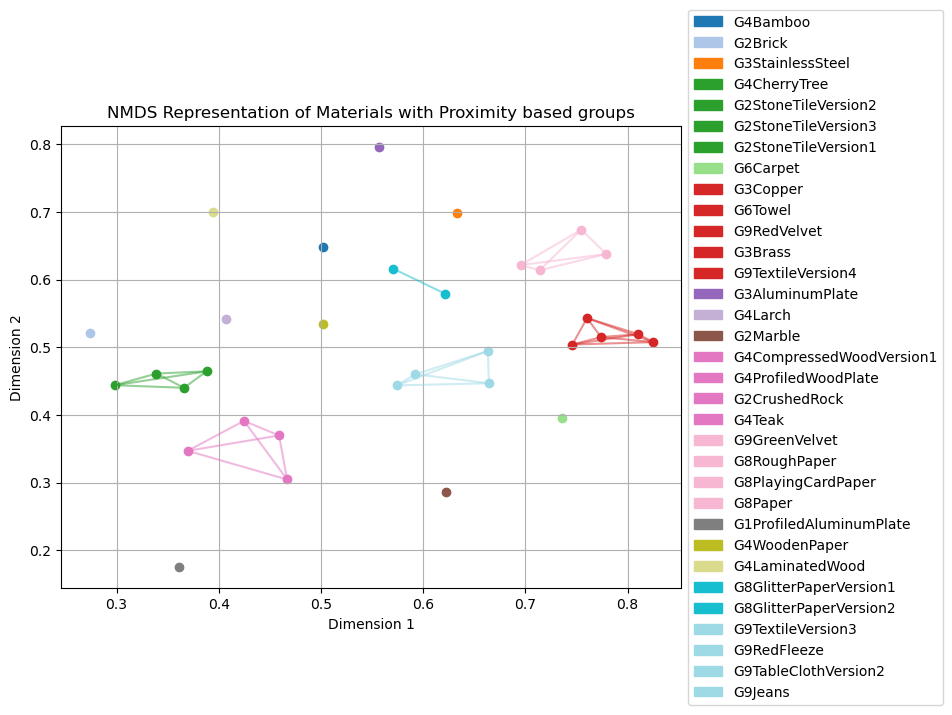

In [12]:
from matplotlib.patches import Patch
distances = np.linalg.norm(optimal_X[:, None] - optimal_X, axis=2)
distances_Y = distances
distance_matrix  = distances_Y

proximity_threshold = 0.075  # Set your desired proximity threshold

# Function to perform clustering based on proximity threshold
def cluster_points(distances, threshold):
    clusters = []
    n = len(distances)

    for i in range(n):
        assigned_to_clusters = []

        for cluster_index, cluster in enumerate(clusters):
            for point in cluster:
                if distances[i][point] < threshold:
                    assigned_to_clusters.append(cluster_index)
                    break

        if not assigned_to_clusters:
            new_cluster = [i]
            clusters.append(new_cluster)
        else:
            # Merge clusters if the point belongs to multiple clusters
            merged_cluster = [i]
            for index in assigned_to_clusters:
                merged_cluster += clusters[index]
                clusters[index] = []
            merged_cluster = list(set(merged_cluster)) 
            clusters = [c for c in clusters if c] 
            clusters.append(merged_cluster)

    return [cluster for cluster in clusters if cluster]



clusters = cluster_points(distance_matrix, proximity_threshold)


colors = plt.cm.tab20(np.linspace(0, 1, len(clusters)))

plt.figure(figsize=(8, 6))

for k in range(len(clusters)):
    this_cluster = clusters[k]
    for points in this_cluster:
        plt.scatter(optimal_X[points][0],optimal_X[points][1], color=colors[k])
        
        
legend_elements = []
legend_labels = []

for i in range(len(optimal_X)):
    legend_elements.append(0)
    legend_labels.append(0)

for k in range(len(clusters)):
    this_cluster = clusters[k]
    for points in this_cluster:
        material_name = list(materials_index.keys())[points]
        legend_labels[points] = material_name
        legend_elements[points] = Patch(color=colors[k])

    
for k in range(len(clusters)):
    this_cluster = clusters[k]
    for indexi in range(len(this_cluster)):
            for indexij in range(indexi,len(this_cluster)):
                i = this_cluster[indexi]
                j = this_cluster[indexij]                
        
                Xis = optimal_X[i]
                Xjs = optimal_X[j]
                points_X = [Xis[0],Xjs[0]]
                points_Y = [Xis[1],Xjs[1]]
                
                plt.plot(points_X, points_Y, color=colors[k], alpha=0.5)
                
new_legend = []
new_legend_labels = []

for k in range(len(clusters)):
    this_cluster = clusters[k]
    for points in this_cluster:
        new_legend.append(legend_elements[points])
        new_legend_labels.append(legend_labels[points])

final_matrix = np.zeros((len(optimal_X),len(optimal_X)),dtype="int")
for i in range(0,len(optimal_X)):
    for j in range(0, len(optimal_X)):
        if distances[i][j] < proximity_threshold:
            final_matrix[i][j] = 1
        
plt.legend(handles=new_legend,labels=new_legend_labels, loc='center left', bbox_to_anchor=(1, 0.5))
plt.xlabel('Dimension 1')
plt.ylabel('Dimension 2')
plt.title('NMDS Representation of Materials with Proximity based groups')
plt.grid(True)
plt.show()

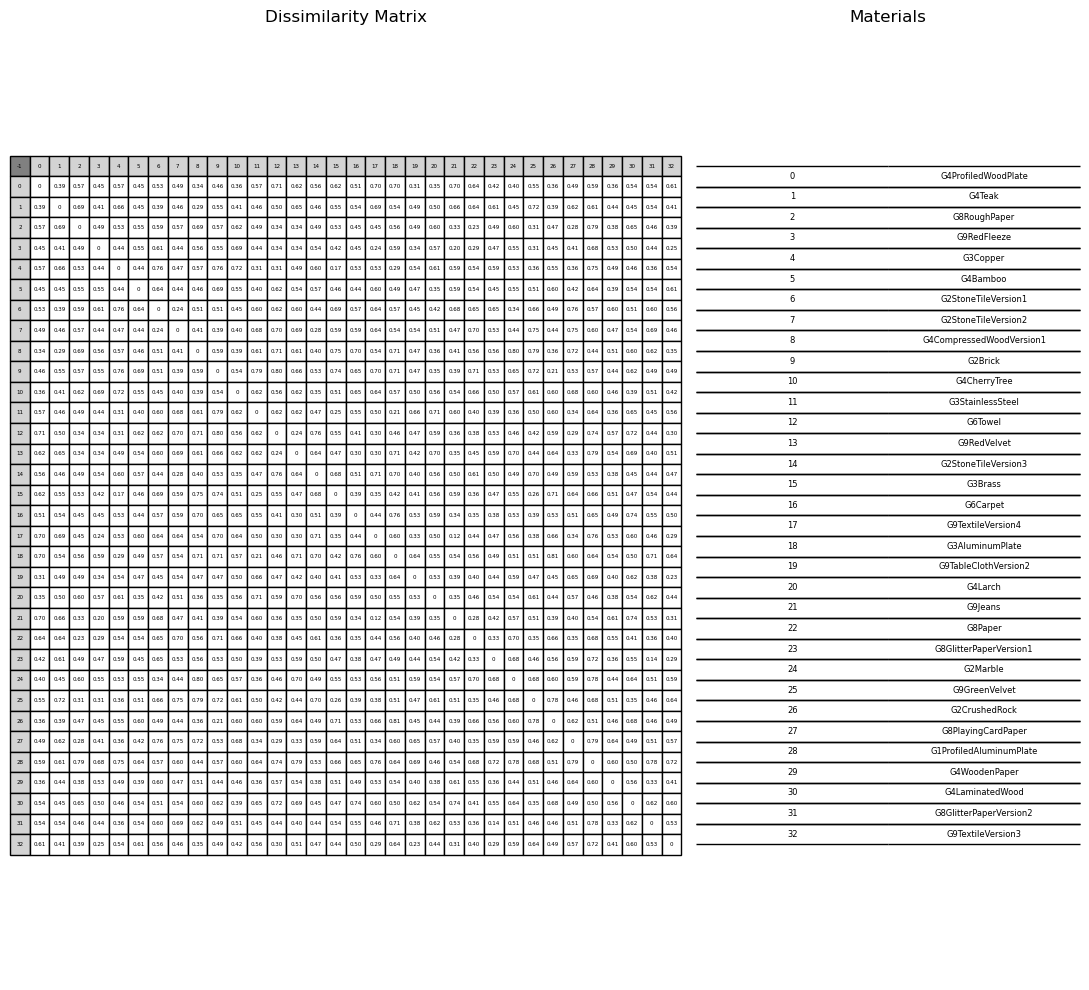

In [13]:


num_rows = len(adjacency_matrix)
num_cols = len(adjacency_matrix[0])


existing_array = adjacency_matrix

index_row = np.arange(existing_array.shape[1], dtype="int").reshape(1, -1)

index_column = np.arange(existing_array.shape[0], dtype="int").reshape(-1, 1)

index_row_column = np.vstack((np.hstack((np.array([[-1]]), index_row)),
                              np.hstack((index_column, existing_array))))
adjacency_matrix_with_indices = index_row_column
num_rows = len(adjacency_matrix_with_indices)
num_cols = len(adjacency_matrix_with_indices[0])


float_array = adjacency_matrix_with_indices
format_func = lambda x: f'{x:.0f}' if x.is_integer() else f'{x:.2f}'

formatted_array = np.array([[format_func(x) for x in row] for row in float_array])
adjacency_matrix_with_indices = formatted_array


fig, axs = plt.subplots(1, 2, figsize=(11, 10), gridspec_kw={'width_ratios': [7, 4]})


main_table = axs[0].table(cellText=adjacency_matrix_with_indices, loc='center', cellLoc='center', edges='closed',
                    )
axs[0].axis('off')  # Hide axis for the main table
axs[0].set_title('Dissimilarity Matrix')

legend = []
for i in range(0, len(materials_index.keys())):
    row = [str(i), list(materials_index.keys())[i]]
    legend.append(row)

sidebar_table = axs[1].table(cellText=legend, loc='center', cellLoc='center', edges='horizontal')
axs[1].axis('off')
axs[1].set_title('Materials')

for cell in main_table.get_celld().values():
    cell.set_fontsize(14)

for cell in sidebar_table.get_celld().values():
    cell.set_fontsize(16)

for row in range(0, num_rows):
    main_table[(row, 0)].set_facecolor('lightgray')  # Row colors
for col in range(0, num_cols):
    main_table[(0, col)].set_facecolor('lightgray')  # Index colors
main_table[(0,0)].set_facecolor("gray")
plt.subplots_adjust(wspace=0.1)
plt.subplots_adjust(left=0.05, right=0.95, bottom=0.1, top=0.9, wspace=0.4)

plt.tight_layout()

# Show the plot
plt.show()


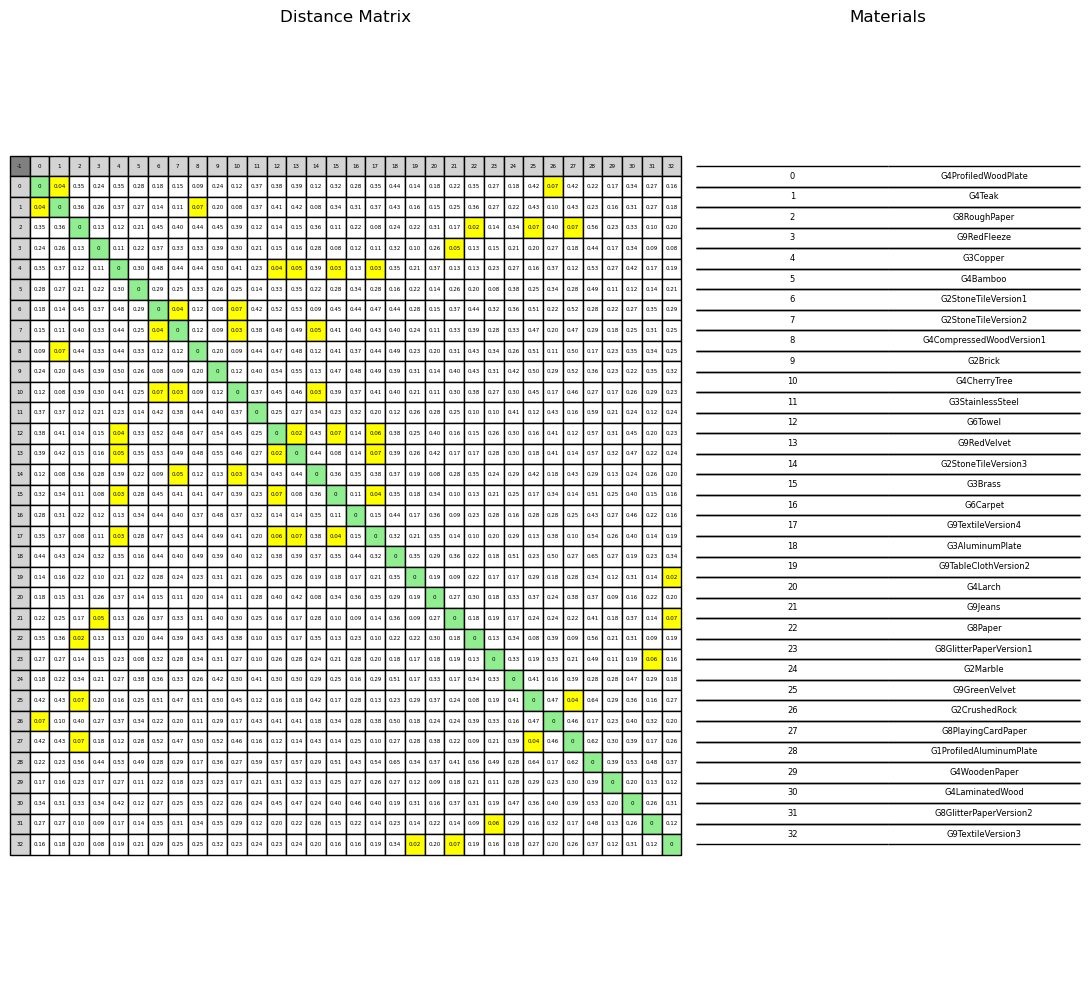

In [14]:
distances_Y = distances

num_rows = len(distances_Y)
num_cols = len(distances_Y[0])

dist_trunc = np.round(distances_Y, 2)
num_rows = len(dist_trunc)
num_cols = len(dist_trunc[0])

existing_array = dist_trunc

index_row = np.arange(existing_array.shape[1], dtype="int").reshape(1, -1)

index_column = np.arange(existing_array.shape[0], dtype="int").reshape(-1, 1)

index_row_column = np.vstack((np.hstack((np.array([[-1]]), index_row)),
                              np.hstack((index_column, existing_array))))
dist_trunc = index_row_column
num_rows = len(dist_trunc)
num_cols = len(dist_trunc[0])
# Colors for the table cells (modify as needed)
cell_colors = [['lightgreen' if i == j else 'yellow' if dist_trunc[i][j] < proximity_threshold else 'white'
                for j in range(num_cols)] for i in range(num_rows)]
float_array = dist_trunc
format_func = lambda x: f'{x:.0f}' if x.is_integer() else f'{x:.2f}'

formatted_array = np.array([[format_func(x) for x in row] for row in float_array])
dist_trunc = formatted_array


fig, axs = plt.subplots(1, 2, figsize=(11, 10), gridspec_kw={'width_ratios': [7, 4]})


main_table = axs[0].table(cellText=dist_trunc, loc='center', cellLoc='center', edges='closed',
                          cellColours=cell_colors)
axs[0].axis('off')  # Hide axis for the main table
axs[0].set_title('Distance Matrix')

legend = []
for i in range(0, len(materials_index.keys())):
    row = [str(i), list(materials_index.keys())[i]]
    legend.append(row)

sidebar_table = axs[1].table(cellText=legend, loc='center', cellLoc='center', edges='horizontal')
axs[1].axis('off')
axs[1].set_title('Materials')

for cell in main_table.get_celld().values():
    cell.set_fontsize(14)

for cell in sidebar_table.get_celld().values():
    cell.set_fontsize(16)

for row in range(0, num_rows):
    main_table[(row, 0)].set_facecolor('lightgray')  # Row colors
for col in range(0, num_cols):
    main_table[(0, col)].set_facecolor('lightgray')  # Index colors
main_table[(0,0)].set_facecolor("gray")
plt.subplots_adjust(wspace=0.1)
plt.subplots_adjust(left=0.05, right=0.95, bottom=0.1, top=0.9, wspace=0.4)

plt.tight_layout()

plt.show()


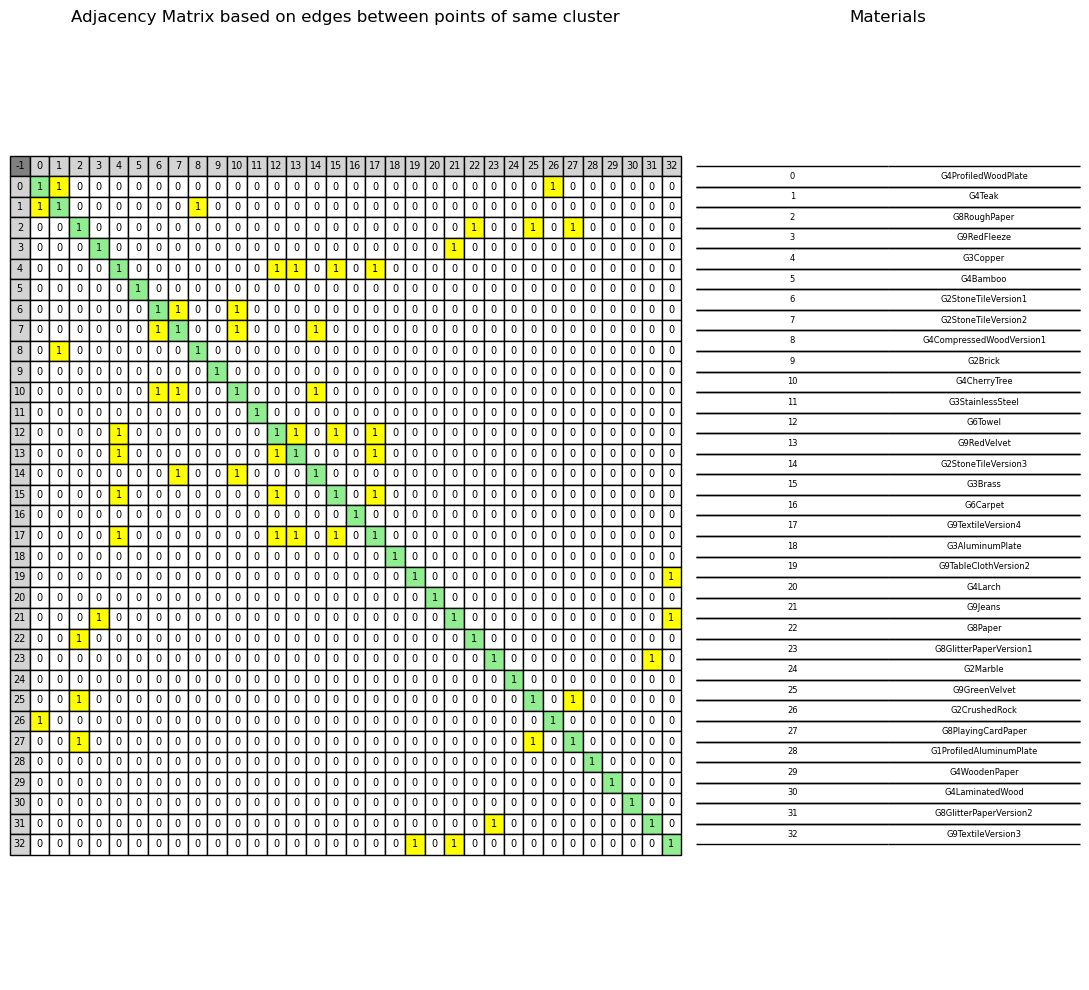

In [15]:
num_rows = len(final_matrix)
num_cols = len(final_matrix)


existing_array = final_matrix

index_row = np.arange(existing_array.shape[1],dtype="int").reshape(1, -1)

index_column = np.arange(existing_array.shape[0],dtype="int").reshape(-1, 1)

index_row_column = np.vstack((np.hstack((np.array([[-1]]), index_row)),
                              np.hstack((index_column, existing_array))))


final_matrix_with_indices = index_row_column

float_array = final_matrix_with_indices
format_func = lambda x: f'{x:.0f}' if x.is_integer() else f'{x:.2f}'

formatted_array = np.array([[format_func(x) for x in row] for row in float_array])

final_matrix_with_indices = formatted_array  



               
fig, axs = plt.subplots(1, 2, figsize=(11, 10), gridspec_kw={'width_ratios': [7, 4]})

main_table = axs[0].table(cellText=final_matrix_with_indices, loc='center', cellLoc='center', edges='closed',
                          cellColours=cell_colors)
axs[0].axis('off')  
axs[0].set_title('Adjacency Matrix based on edges between points of same cluster')

legend = []
for i in range(0, len(materials_index.keys())):
    row = [str(i), list(materials_index.keys())[i]]
    legend.append(row)

sidebar_table = axs[1].table(cellText=legend, loc='center', cellLoc='center', edges='horizontal')
axs[1].axis('off')
axs[1].set_title('Materials')

for cell in main_table.get_celld().values():
    cell.set_fontsize(14)

for cell in sidebar_table.get_celld().values():
    cell.set_fontsize(16)

for row in range(1, num_rows + 1):
    main_table[(row, 0)].set_facecolor('lightgray')  # Row colors
for col in range(1, num_cols + 1):
    main_table[(0, col)].set_facecolor('lightgray')  # Index colors
main_table[(0,0)].set_facecolor('gray')  # Index colors
plt.subplots_adjust(wspace=0.1)
plt.subplots_adjust(left=0.05, right=0.95, bottom=0.1, top=0.9, wspace=0.4)

plt.tight_layout()

plt.show()


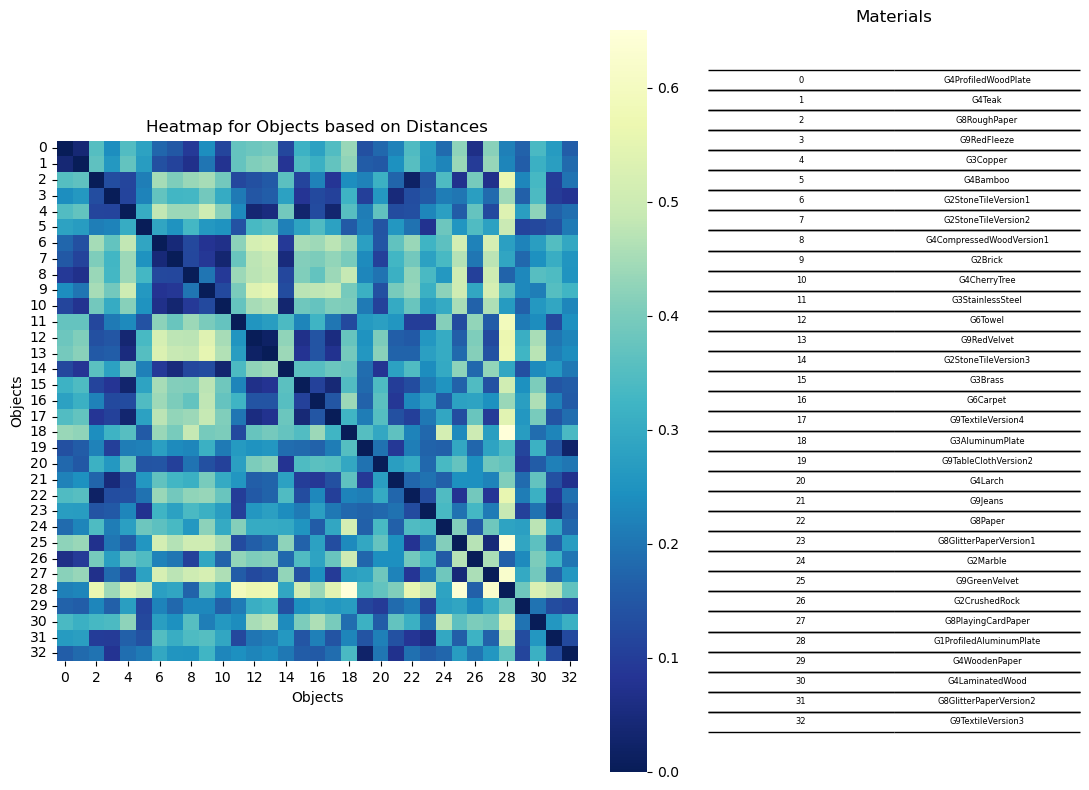

In [16]:
fig, axs = plt.subplots(1, 2, figsize=(11, 8),gridspec_kw={'width_ratios': [7, 4]})

sns.heatmap(distances_Y, cmap='YlGnBu_r', fmt='.2f', ax=axs[0], square = True)  # Specify height ratios for subplots
axs[0].set_title('Heatmap for Objects based on Distances')
axs[0].set_xlabel('Objects')
axs[0].set_ylabel('Objects')
sidebar_table = axs[1].table(cellText=legend, loc='center', cellLoc='center', edges='horizontal')
axs[1].axis('off')  
axs[1].set_title('Materials')

for cell in main_table.get_celld().values():
    cell.set_fontsize(14)  # Change font size for main table text

for cell in sidebar_table.get_celld().values():
    cell.set_fontsize(16)  #

plt.subplots_adjust(wspace=0.05) 
plt.subplots_adjust(left=0.05, right=0.95, bottom=0.1, top=0.9, wspace=0.4)

plt.tight_layout()

plt.show()

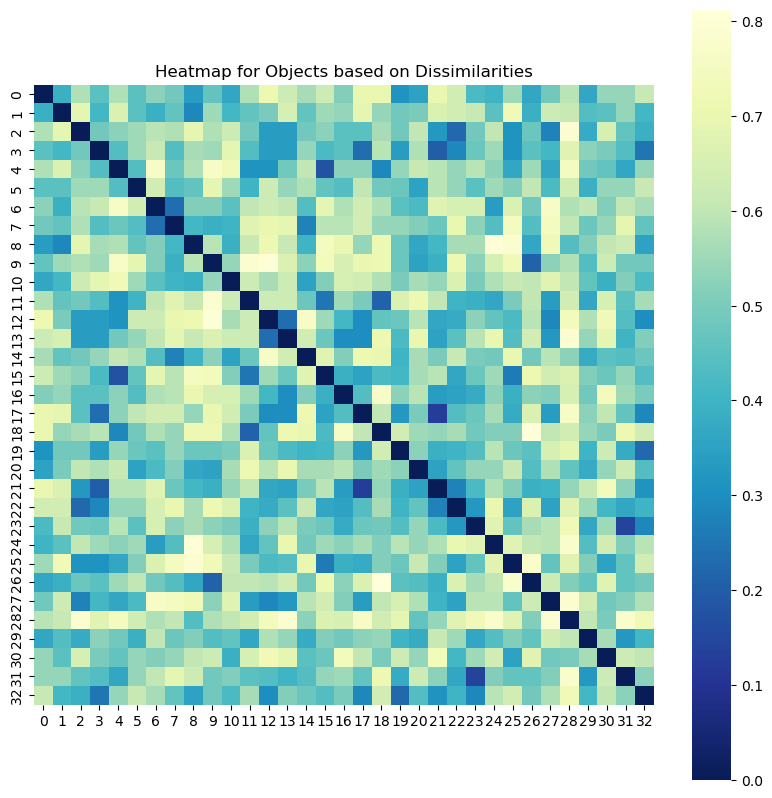

In [17]:
plt.figure(figsize=(10, 10))
sns.heatmap(adjacency_matrix, cmap='YlGnBu_r', fmt='.2f', square = True) 
plt.title('Heatmap for Objects based on Dissimilarities')

plt.show()

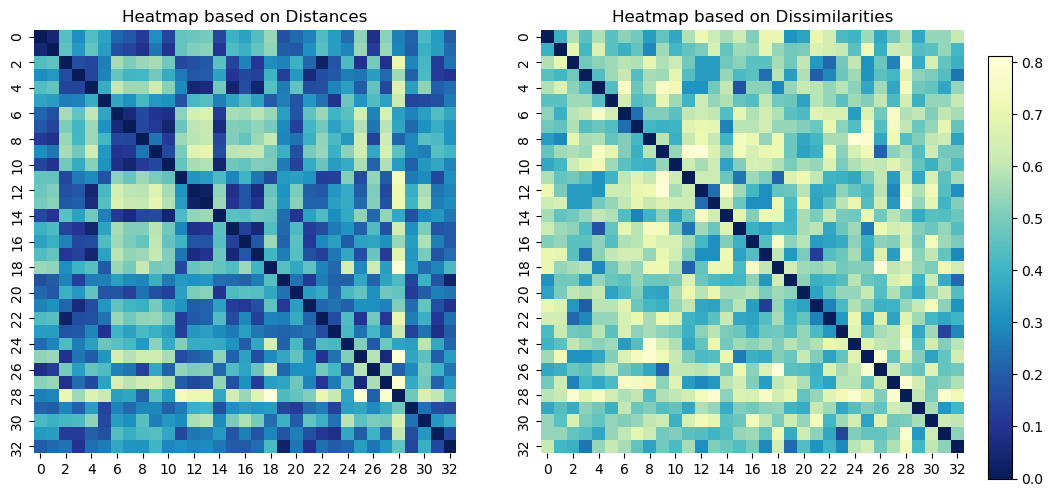

In [18]:
fig, axs = plt.subplots(1, 2, figsize=(12, 6), gridspec_kw={'width_ratios': [5, 5]})  # Create subplots with 1 row and 2 columns

# Plot the first heatmap on the left subplot (axs[0])
heatmap1 = sns.heatmap(distances_Y, cmap='YlGnBu_r', fmt='.2f', square=True, cbar=False, ax=axs[0])
axs[0].set_title('Heatmap based on Distances')

# Plot the second heatmap on the right subplot (axs[1])
heatmap2 = sns.heatmap(adjacency_matrix, cmap='YlGnBu_r', fmt='.2f', square=True, cbar=False, ax=axs[1])
axs[1].set_title('Heatmap based on Dissimilarities')

# Get the maximum height of the two subplots
max_height = max(axs[0].get_position().height, axs[1].get_position().height)

# Create a color bar based on the maximum height of subplots
cbar_ax = fig.add_axes([0.92, 0.1, 0.02, max_height])  # Position for color bar
fig.colorbar(heatmap2.collections[0], cax=cbar_ax)  # Use the collections attribute to get the correct color bar


# Show the plot
plt.show()


In [19]:
distance_Adj_matrix = np.round(distances_Y,2)
distance_dataframe = pd.DataFrame(distance_Adj_matrix)
distance_dataframe.to_csv("./distance_adjacency_matrix.csv", header=False, index=False)
diss_dataframe = pd.DataFrame(adjacency_matrix)
diss_dataframe.to_csv("./dissimilarity_adjacency_matrix.csv", header=False, index=False)
final_matrix_csv = pd.DataFrame(final_matrix)
final_matrix_csv.to_csv("./final_adjacency_matrix_edges.csv", header=False, index=False)

mymaterials_with_OUT_INDEX = list(materials_index.keys())

distance_dataframe = pd.read_csv("./distance_adjacency_matrix.csv", header=None)
diss_dataframe = pd.read_csv("./dissimilarity_adjacency_matrix.csv", header=None)
final_matrix_csv = pd.read_csv("./final_adjacency_matrix_edges.csv", header=None)

distance_dataframe.columns = mymaterials_with_OUT_INDEX
distance_dataframe.index = mymaterials_with_OUT_INDEX

diss_dataframe.columns = mymaterials_with_OUT_INDEX
diss_dataframe.index = mymaterials_with_OUT_INDEX

final_matrix_csv.columns = mymaterials_with_OUT_INDEX
final_matrix_csv.index = mymaterials_with_OUT_INDEX

# Save modified DataFrames back to CSV files
distance_dataframe.to_csv("./distance_adjacency_matrix.csv")
diss_dataframe.to_csv("./dissimilarity_adjacency_matrix.csv")
final_matrix_csv.to_csv("./final_adjacency_matrix_edges.csv")

In [20]:
disparity_matrix = transform_to_disparity(adjacency_matrix)
flatten_dissimilarity = []
flatten_disparity = []
flatten_Y = []
for j in range(0, adjacency_matrix.shape[0]):
    for i in range(0,j):
        flatten_dissimilarity.append(adjacency_matrix[i][j])
        flatten_disparity.append(disparity_matrix[i][j])
        flatten_Y.append(distances_Y[i][j])
pairs = []

for i in range(0, len(flatten_disparity)):
    pairs.append((flatten_dissimilarity[i],flatten_disparity[i]))

plotx = []
ploty = []
sorted_pairs = sorted(pairs, key=lambda x: x[0])
for k in range(0,len(sorted_pairs)):
    plotx.append(sorted_pairs[k][0])
    ploty.append(sorted_pairs[k][1])



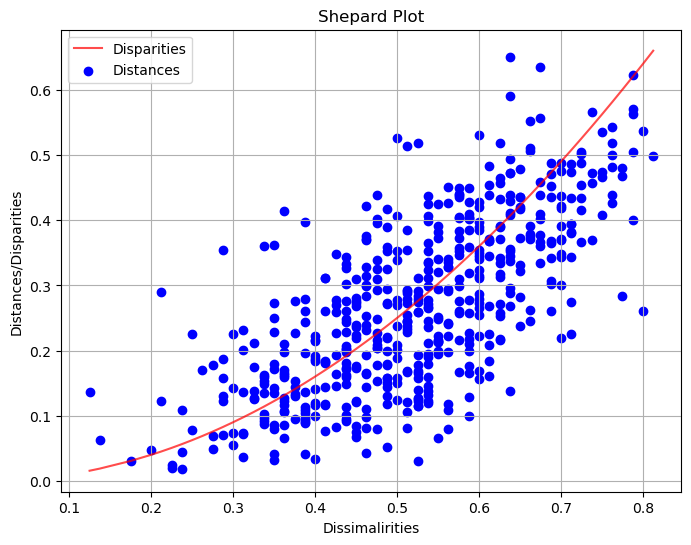

In [21]:
plt.figure(figsize=(8, 6))
plt.plot(plotx, ploty, color='red', label='Disparities', alpha=0.7)
plt.title('Shepard Plot')
plt.xlabel('Dissimalirities')
plt.ylabel('Distances/Disparities')
plt.grid(True)

# Adding the line plot representing the sorted pairs
plt.scatter(flatten_dissimilarity,flatten_Y, color='blue', label='Distances')
plt.legend()

plt.show()